In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [04:02<00:00, 20.64it/s]


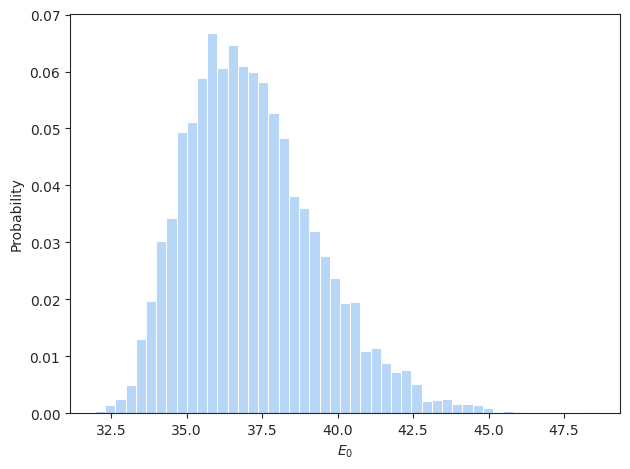

In [36]:
import numpy as np
from scipy.sparse.linalg import eigsh
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

from nonlocalgames.hamiltonians import G14

values = []
ham = G14(init_mode='normal')
for i in tqdm(range(5000)):
    ham.init(seed=i)
    w, _ = eigsh(ham.mat, k=1, which='LA')
    values.append(w.item())

sns.histplot(data=values, stat='probability')
plt.xlabel('$E_0$')
plt.tight_layout()
plt.savefig('plots/g14/g14_random_init.png', dpi=300)

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%%bash

# Run trials with multiprocessing
python examples/g14/run_g14.py \
    --num-cpus=4 \
    --seeds=data/seeds.txt
    -n 50

10418.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


2023-08-15 16:31:25,106	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
Starting processing
100%|███████████████████████████████████████████| 50/50 [21:37<00:00, 25.95s/it]
Postprocessing
Aggregating results


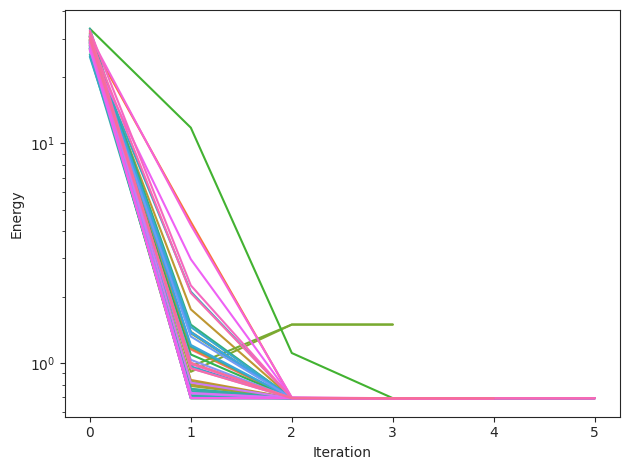

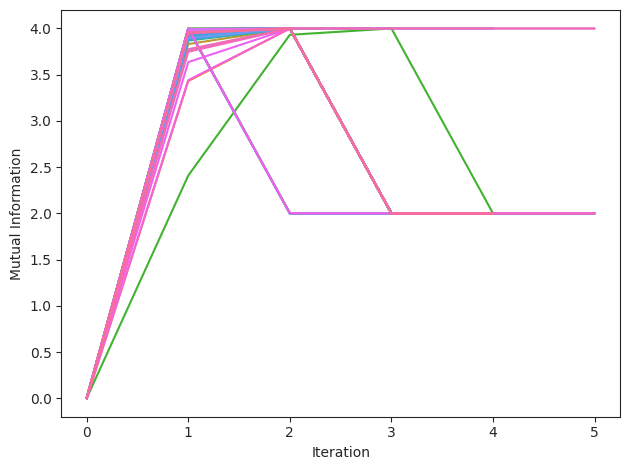

In [21]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

df = pd.read_csv('data/g14_trials.csv')
sns.lineplot(data=df, x='iter', y='energy', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/g14_trials.png', dpi=300)
plt.show()

sns.lineplot(data=df, x='iter', y='mutual_information', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.savefig('plots/g14_mutual_information.png', dpi=300)
plt.show()

### Test generated circuit

We're going to load the saved ADAPT ansatz and convert it to a Qiskit circuit. Then, we'll use the utility class `NLGCircuit` to evaluate each of the possible referee questions on G14.

In [1]:
%load_ext autoreload
%autoreload 2

2023-08-17 13:11:14,118	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


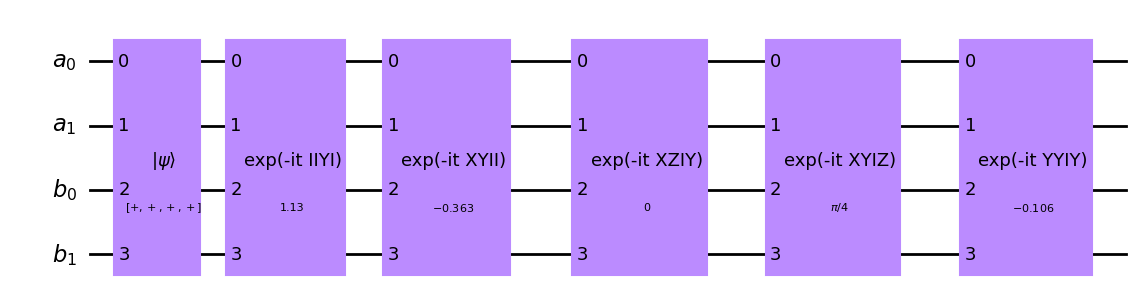

In [2]:
import json
import numpy as np

# Qiskit has deprecated code inside of it
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    from qiskit_aer import AerSimulator

    from nonlocalgames.hamiltonians import G14
    from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        '++++',
        [qubits] * players,
        adapt_order=False)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    return qc, phi

# Load best circuit
shared_state, phi = load_g14_circuit('data/g14_imbalanced/g14_state.json')
shared_state.draw('mpl')

Construct the `NLGCircuit` from the ansatz, and draw it to make sure it looks reasonable.

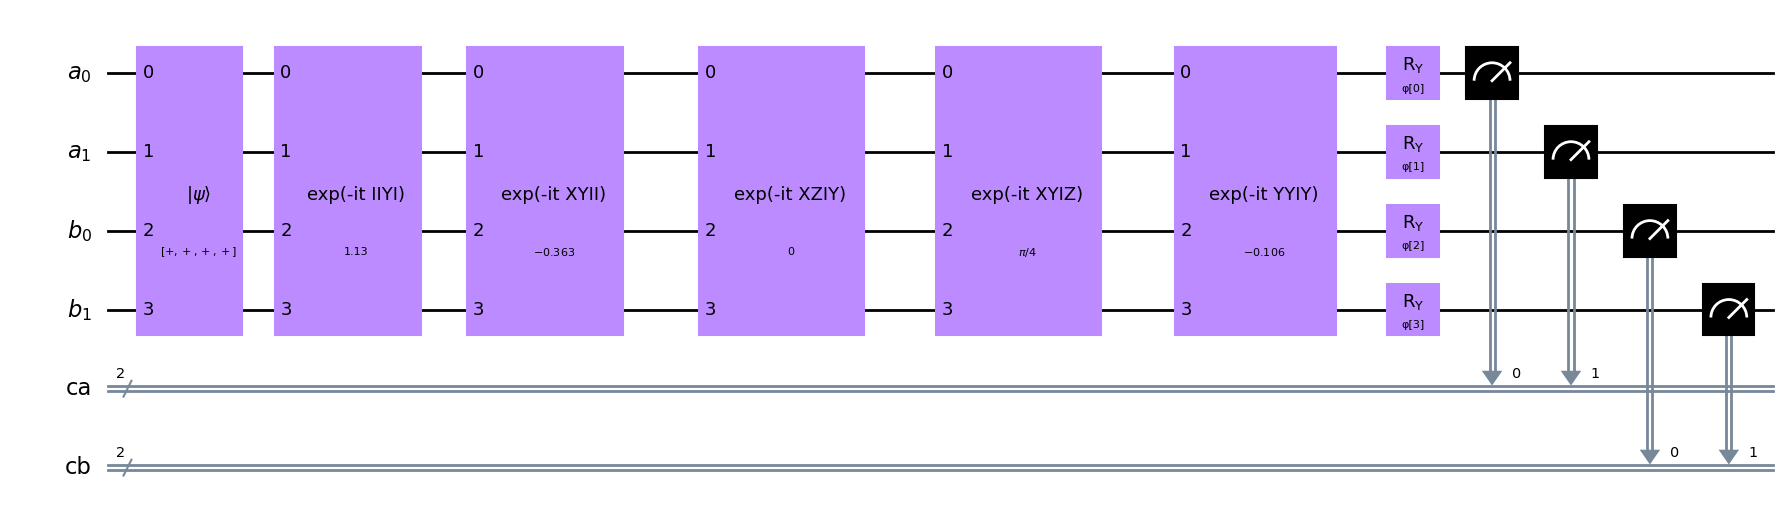

In [5]:
import matplotlib.pyplot as plt

sim = AerSimulator()
nlg = NLGCircuit(shared_state, phi, sim=sim)
fig: plt.Figure = nlg.qc.draw('mpl')
fig.tight_layout()
fig.savefig('plots/g14_imbalanced/circuit.png', dpi=300)
fig

Here's a sample response where $v_a = v_b = 1$. The players should respond with the same color $c_a = c_b$ to win.

In [81]:
nlg.ask([1, 1], shots=1024, seed_simulator=42)

{(2, 2): 519, (3, 3): 505}

Construct a dataframe consisting of 1024 trials (shots) for each possible question.

In [82]:
import pandas as pd

vertices = [(i, i) for i in range(14)]
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges
shots = 1024

records = []
for va, vb in questions:
    counts = nlg.ask((va, vb), shots=shots, seed_simulator=42)
    for (ca, cb), n in counts.items():
        records.append({
            'va': va,
            'vb': vb,
            'ca': ca,
            'cb': cb,
            'n': n
        })

df = pd.DataFrame.from_records(records)
df.to_csv('data/g14_imbalanced/g14_responses.csv', index=False)
df

,va,vb,ca,cb,n
0,0,0,0,0,519
1,0,0,1,1,505
2,1,1,2,2,519
3,1,1,3,3,505
4,2,2,0,0,519
...,...,...,...,...,...
263,10,13,1,3,477
264,11,13,0,3,519
265,11,13,1,2,505
266,12,13,2,3,519


We'd like to calculate the win rate for each question.

In [83]:
def winrate(gdf: pd.DataFrame):
    if np.all(gdf.va == gdf.vb):
        return gdf.loc[gdf.ca == gdf.cb].n.sum() / shots
    else:
        return gdf.loc[gdf.ca != gdf.cb].n.sum() / shots

wr = df.groupby(['va', 'vb']).apply(winrate).reset_index(name='win_rate')
wr.to_csv('data/g14_imbalanced/g14_win_rate.csv', index=False)
wr

,va,vb,win_rate
0,0,0,1.000000
1,0,1,1.000000
2,0,2,0.936523
3,0,3,1.000000
4,0,4,0.936523
...,...,...,...
83,13,9,1.000000
84,13,10,1.000000
85,13,11,1.000000
86,13,12,1.000000


Plot the win rate per question type (either $v_a = v_b$ or $v_a \sim v_b$).

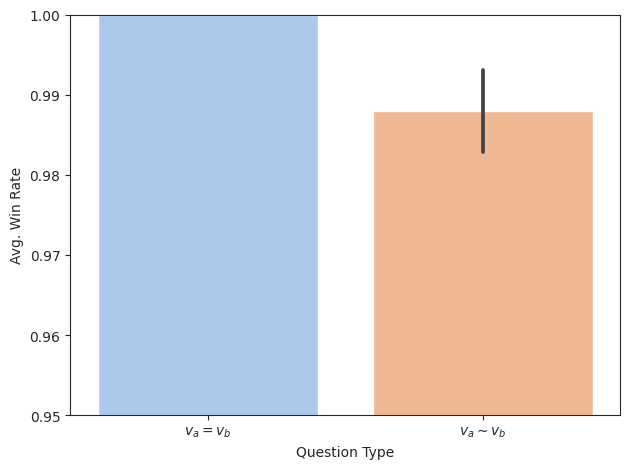

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('pastel')

wr['question'] = np.where(wr.va == wr.vb, r'$v_a = v_b$', r'$v_a \sim v_b$')

sns.barplot(data=wr, x='question', y='win_rate')
plt.xlabel('Question Type')
plt.ylabel('Avg. Win Rate')
plt.ylim(0.95, 1)
plt.tight_layout()
plt.savefig('plots/g14_imbalanced/g14_win_rate.png', dpi=300)
plt.show()

Calculate the balance of the question types. The fact that there's many more edge questions than vertex questions suggests we should re-weight the hamiltonian terms, similar to if we had an imbalanced dataset in a supervised learning problem.

In [87]:
print(wr.question.value_counts())

$v_a \sim v_b$    74
$v_a = v_b$       14
Name: question, dtype: int64


### G14 Balanced

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# Run trials with multiprocessing
!(python examples/g14/run_g14.py \
    --num-cpus=6 \
    --seeds=data/seeds.txt \
    -n 50 \
    --weighting=balanced \
    --adapt-tol=1e-6 \
    --dpo-tol=1e-6)

2023-08-17 16:52:41,196	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
Starting processing
100%|███████████████████████████████████████████| 50/50 [24:03<00:00, 28.87s/it]
Postprocessing
Aggregating results


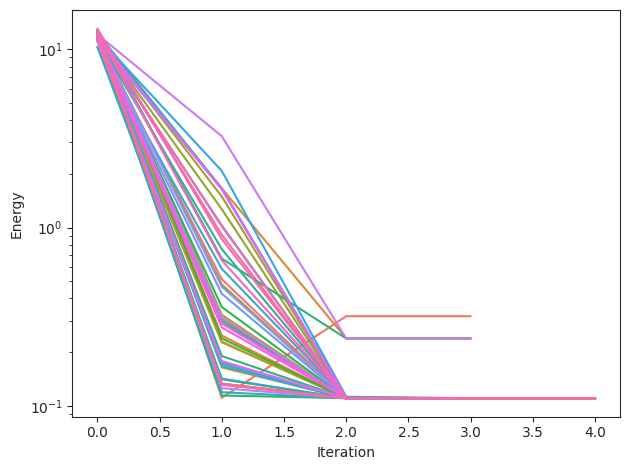

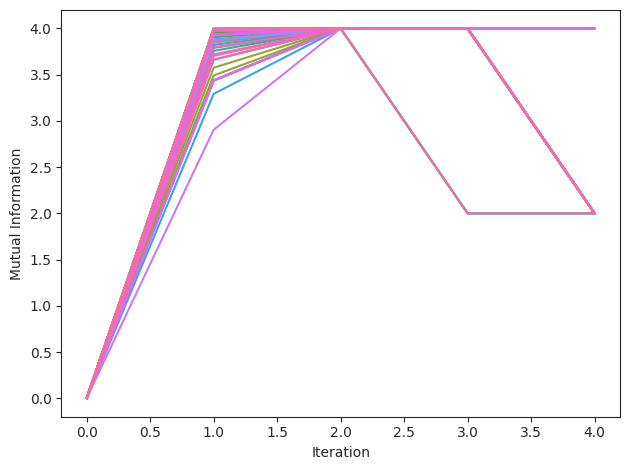

In [5]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

df = pd.read_csv('data/g14_balanced/g14_trials.csv')
sns.lineplot(data=df, x='iter', y='energy', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/g14_balanced/g14_trials.png', dpi=300)
plt.show()

sns.lineplot(data=df, x='iter', y='mutual_information', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.savefig('plots/g14_balanced/g14_mutual_information.png', dpi=300)
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2023-08-17 17:18:05,153	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


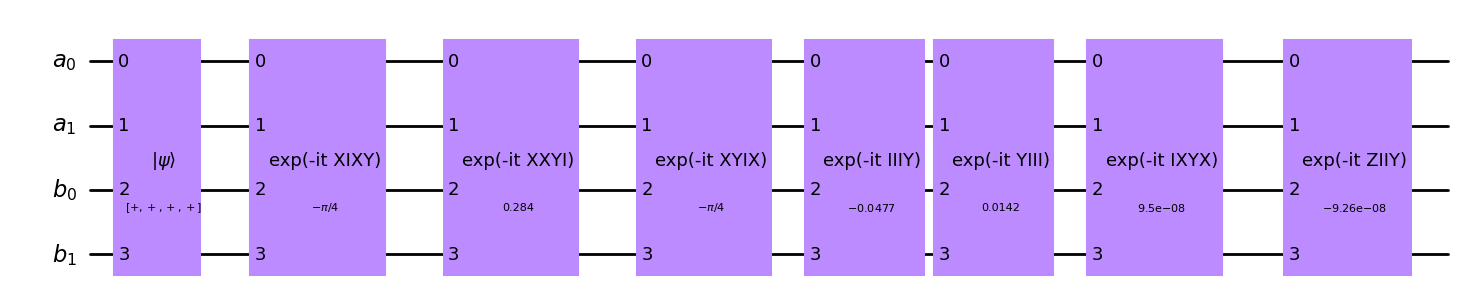

In [6]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np

# Qiskit has deprecated code inside of it
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    from qiskit_aer import AerSimulator

    from nonlocalgames.hamiltonians import G14
    from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        '++++',
        [qubits] * players,
        adapt_order=False)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    return qc, phi

# Load best circuit
shared_state, phi = load_g14_circuit('data/g14_balanced/g14_state.json')
shared_state.draw('mpl')

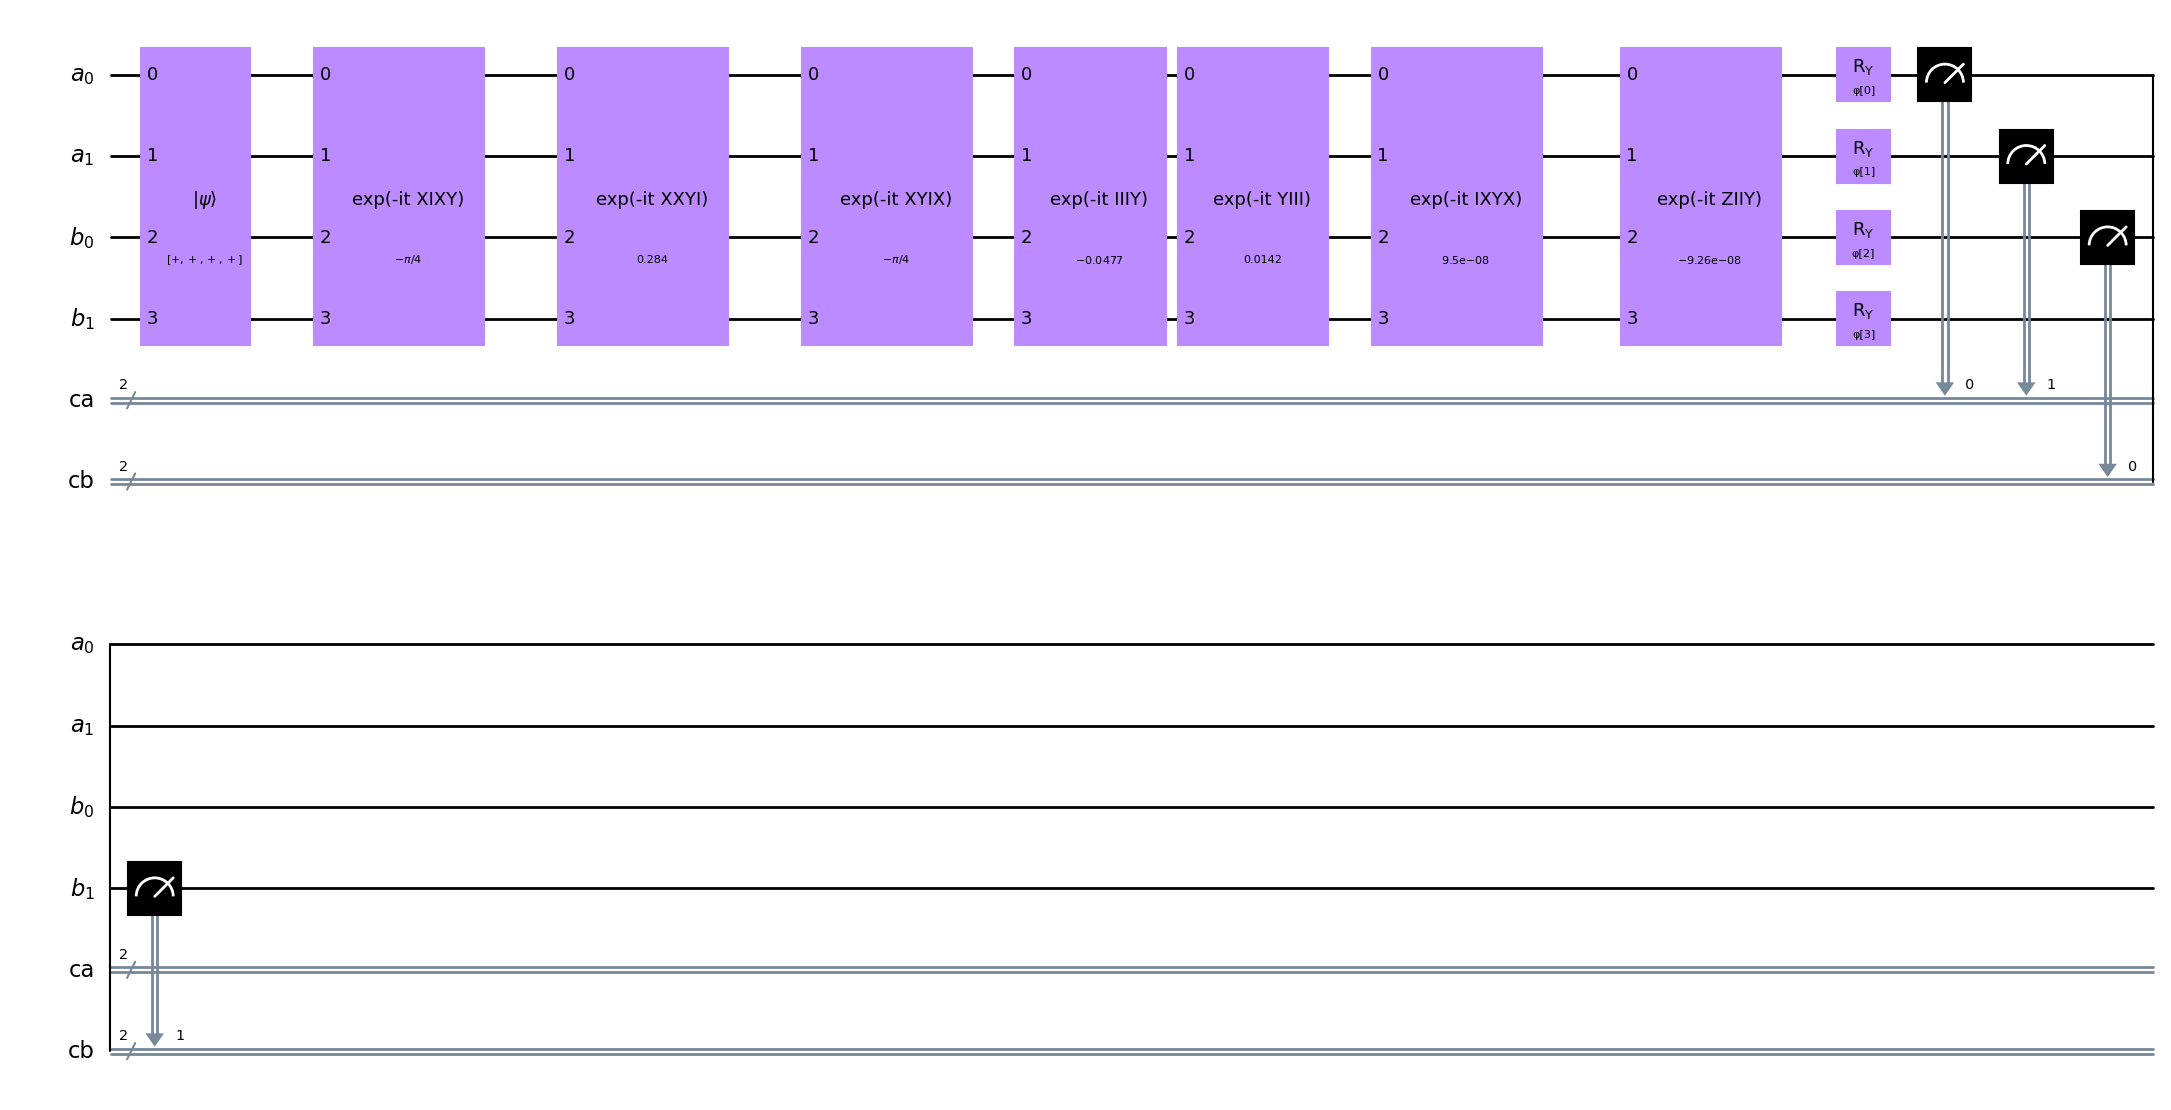

In [7]:
import matplotlib.pyplot as plt

sim = AerSimulator()
nlg = NLGCircuit(shared_state, phi, sim=sim)
fig: plt.Figure = nlg.qc.draw('mpl')
fig.tight_layout()
fig.savefig('plots/g14_balanced/circuit.png', dpi=300)
fig

In [8]:
import pandas as pd

vertices = [(i, i) for i in range(14)]
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges
shots = 1024

records = []
for va, vb in questions:
    counts = nlg.ask((va, vb), shots=shots, seed_simulator=42)
    for (ca, cb), n in counts.items():
        records.append({
            'va': va,
            'vb': vb,
            'ca': ca,
            'cb': cb,
            'n': n
        })

df = pd.DataFrame.from_records(records)
df.to_csv('data/g14_balanced/g14_responses.csv', index=False)
df

,va,vb,ca,cb,n
0,0,0,2,2,519
1,0,0,3,3,505
2,1,1,0,0,519
3,1,1,1,1,505
4,2,2,2,2,519
...,...,...,...,...,...
263,11,13,3,1,477
264,12,13,2,0,495
265,12,13,2,1,24
266,12,13,3,0,28


In [9]:
def winrate(gdf: pd.DataFrame):
    if np.all(gdf.va == gdf.vb):
        return gdf.loc[gdf.ca == gdf.cb].n.sum() / shots
    else:
        return gdf.loc[gdf.ca != gdf.cb].n.sum() / shots

wr = df.groupby(['va', 'vb']).apply(winrate).reset_index(name='win_rate')
wr.to_csv('data/g14_balanced/g14_win_rate.csv', index=False)
wr

,va,vb,win_rate
0,0,0,1.000000
1,0,1,1.000000
2,0,2,0.936523
3,0,3,0.936523
4,0,4,1.000000
...,...,...,...
83,13,9,1.000000
84,13,10,1.000000
85,13,11,1.000000
86,13,12,1.000000


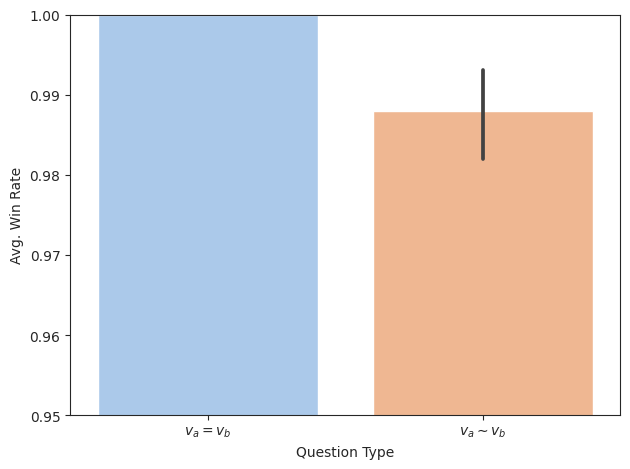

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('pastel')

wr['question'] = np.where(wr.va == wr.vb, r'$v_a = v_b$', r'$v_a \sim v_b$')

sns.barplot(data=wr, x='question', y='win_rate')
plt.xlabel('Question Type')
plt.ylabel('Avg. Win Rate')
plt.ylim(0.95, 1)
plt.tight_layout()
plt.savefig('plots/g14_balanced/g14_win_rate.png', dpi=300)
plt.show()

In [11]:
wr.win_rate.mean(), wr.win_rate.std()

(0.9899014559659091, 0.02335029197038263)

## Fine-tuning the strategy with U3 gates

In [9]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import openfermion as of

# Qiskit has deprecated code inside of it
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    from qiskit_aer import AerSimulator

    from adaptgym import AdaptiveAnsatz

    from nonlocalgames.hamiltonians import G14
    from nonlocalgames.circuit import (
        NLGCircuit,
        load_adapt_ansatz,
        qubitop_from_str
    )

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        '++++',
        [qubits] * players,
        adapt_order=False)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    return qc, phi

def load_g14_adapt_ansatz(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    state = data['state']
    phi = np.array(data['phi'])

    ham = G14(weighting='balanced', measurement_layer='u3')
    params = ham.params.reshape(ham.desired_shape)
    params[:, :, :, 0] = phi
    ham.init()

    ansatz = AdaptiveAnsatz(ham.mat, ham.ref_ket)
    for theta, op_str in state:
        op = qubitop_from_str(op_str)
        ansatz.params.insert(0, theta)
        ansatz.G.insert(0, of.get_sparse_operator(op, n_qubits=4))
        ansatz.is_qubit_op.insert(0, True)
    
    return ansatz, ham, phi

# Load best circuit
shared_state, ham, phi = load_g14_adapt_ansatz('data/g14_balanced/g14_state.json')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from scipy.optimize import minimize, OptimizeResult

ket = shared_state.prepare_state()
bra = ket.conj().T

def get_energy(p: np.ndarray):
    ham.params = p
    E = bra @ ham.mat @ ket
    E = E.item().real
    return E

res = minimize(get_energy, ham.params, method='BFGS', tol=1e-9)
res

KeyboardInterrupt: 

In [14]:
p = ham.params.reshape(ham.desired_shape)
p[:, :, :, 1:].min()

-3.1769020835063844e-07

In [8]:
np.abs(res.jac).max()

4.730187356472015e-06

In [2]:
%load_ext autoreload
%autoreload 2

from nonlocalgames import methods
from nonlocalgames.hamiltonians import G14

state, phi, metrics = methods.dual_phase_optim(
    G14(weighting='balanced', measurement_layer='u3'),
    save_mutual_information=True,
    seed=42
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/nineonefive/miniconda3/envs/adapt-gym/lib/python3.10/site-packages/gymnasium/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/nineonefive/miniconda3/envs/adapt-gym/lib/python3.10/site-packages/gymnasium/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/nineonefive/miniconda3/envs/adapt-gym/lib/python3.10/site-packages/gymnasium/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
metrics

{'energy': [11.768889318752839,
  0.18607146328867918,
  0.110286279998931,
  0.11028466984452524],
 'mutual_information': [1.92205590228895e-15,
  3.9026433052900624,
  3.999999385964827,
  1.9999999999999818],
 'adapt_pool_gradmax': [0,
  0.0005082957895532481,
  0.0009098861211416127,
  5.5754690809118115e-05],
 'phi_grad': array([ 1.05239451e-07, -4.65661287e-09, -1.11758709e-08, -1.00582838e-07,
        -8.38190317e-09,  1.39698386e-08,  4.93600965e-08,  1.76951289e-08,
        -8.37258995e-07,  4.90806997e-07,  7.45058060e-09, -5.02914190e-08,
        -1.21071935e-08,  5.58793545e-09,  8.01868737e-07, -2.80328095e-07,
         9.31322575e-10, -6.23986125e-08,  3.72529030e-09, -1.86264515e-09,
         2.42143869e-08, -5.21540642e-08, -1.21071935e-08,  2.71946192e-07,
        -2.56113708e-07, -1.49011612e-08, -3.16649675e-08, -3.81842256e-07,
        -1.11758709e-08,  1.15483999e-07, -7.91624188e-08, -1.86264515e-09,
         2.46800482e-07, -2.70083547e-08, -6.51925802e-09, -3.25

In [4]:
state

[(0.7853980067845919, '1j [Y1 Z3]'),
 (0.49882447408875835, '1j [X0 Z1 Y2 Z3]'),
 (0.37355890712281076, '1j [X0 Y1 X2 Y3]'),
 (0.4694997077678845, '1j [X0 Z3]'),
 (0.6057062592752048, '1j [Y3]'),
 (-0.15300998250651315, '1j [Z0]'),
 (-0.12471920491990426, '1j [Y0]'),
 (0.07099316473412808, '1j [Z3]')]

In [5]:
phi.shape

(168,)

In [7]:
import json
import numpy as np

with open('data/g14_balanced/g14_state.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

phi = np.array(data['phi'])
phi = (phi + np.pi) % (2 * np.pi)
phi -= np.pi

for q in range(14):
    print(q)
    print('Alice:', phi[0, q])
    print('Bob:', phi[1, q])

0
Alice: [ 3.02669745 -0.16476415]
Bob: [-2.48639639  1.9802681 ]
1
Alice: [-0.11489595 -1.51076285]
Bob: [0.65519711 0.6342693 ]
2
Alice: [-0.11489393  1.18202771]
Bob: [ 0.6551958  -2.95612531]
3
Alice: [-0.1148955 -0.164374 ]
Bob: [0.65519628 1.98065849]
4
Alice: [-0.11489526  2.97722069]
Bob: [ 0.65519652 -1.16093238]
5
Alice: [ 3.02670318 -0.16476753]
Bob: [-2.48640076  1.9802649 ]
6
Alice: [-0.11489367  2.07962761]
Bob: [ 0.65519615 -2.05852537]
7
Alice: [-0.11489596 -2.40836436]
Bob: [ 0.65519793 -0.26333191]
8
Alice: [ 3.02669264 -0.16476107]
Bob: [-2.48639061  1.98027134]
9
Alice: [-0.11488984 -0.61316981]
Bob: [0.65519186 1.53186244]
10
Alice: [ 3.02669747 -0.16476453]
Bob: [-2.48639622  1.98026811]
11
Alice: [-0.11489482  2.97721697]
Bob: [ 0.65519677 -1.16093624]
12
Alice: [-0.11489997  0.28442981]
Bob: [0.65520151 2.42946191]
13
Alice: [3.02669789 2.97682817]
Bob: [-2.48639589 -1.1613248 ]


## Load G14 and Plot Graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


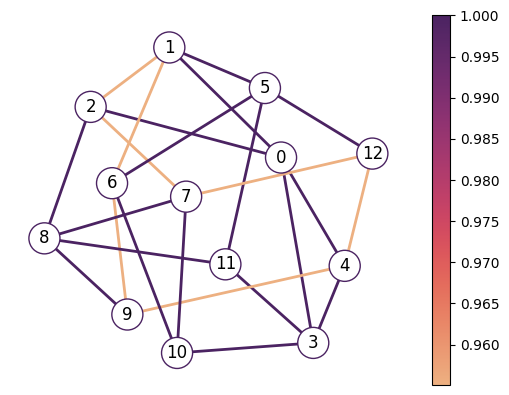

In [13]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from nonlocalgames.hamiltonians import G14
from nonlocalgames import util

df = pd.read_csv('data/g14_balanced/g14_win_rate.csv')
g14 = G14._get_graph()

graph = nx.Graph()
for node in range(len(g14.nodes)):
    if node == 13:
        continue

    weight = df.loc[(df.va == node) & (df.vb == node), 'win_rate'].item()
    graph.add_node(node, weight=weight)

for v1, v2 in g14.edge_links:
    if v1 == 13 or v2 == 13 or graph.has_edge(v2, v1):
        continue

    weight = min(
                df.loc[(df.va == v1) & (df.vb == v2), 'win_rate'].item(),
                df.loc[(df.va == v2) & (df.vb == v1), 'win_rate'].item(),
            )

    graph.add_edge(v1, v2, weight=weight)

util.draw_graph(graph, sns.color_palette('flare', as_cmap=True))
plt.show()

### Nonviolation Hamiltonian Results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(2, 14, 2)


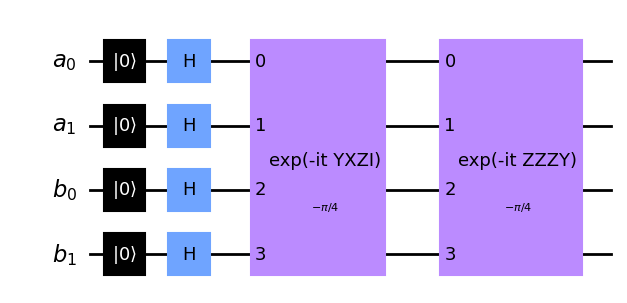

In [2]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np

# Qiskit has deprecated code inside of it
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    from qiskit_aer import AerSimulator

    from nonlocalgames.hamiltonians import G14
    from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        '++++',
        [qubits] * players,
        adapt_order=False)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    return qc, phi

# Load best circuit
shared_state, phi = load_g14_circuit('data/g14_constrained/g14_state.json')

# Stack parameter vector
phi = np.array([phi, phi])
phi = np.squeeze(phi)
print(phi.shape)
shared_state.draw('mpl')

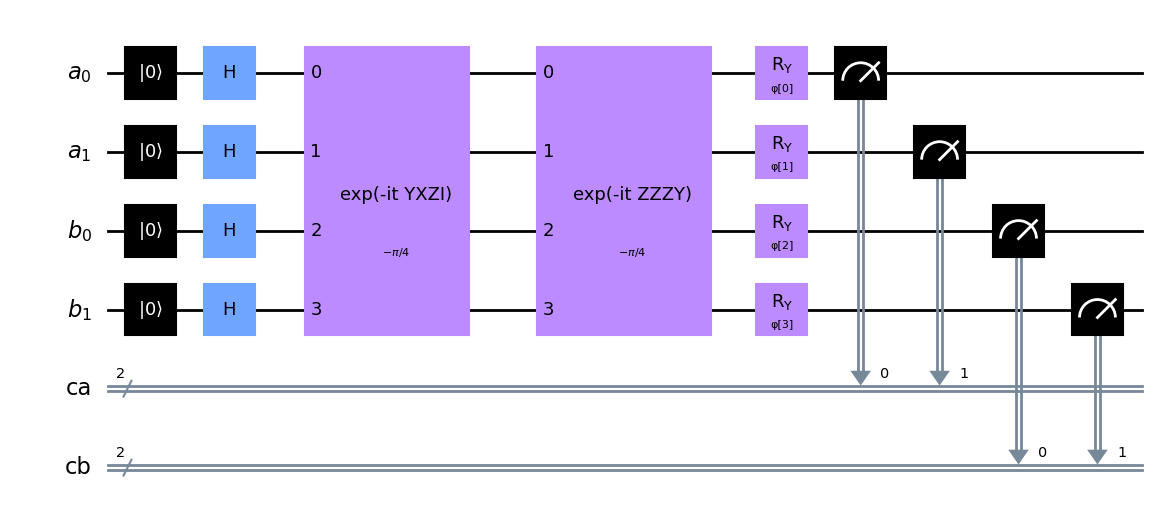

In [38]:
import matplotlib.pyplot as plt

sim = AerSimulator()
nlg = NLGCircuit(shared_state, phi, sim=sim)
fig: plt.Figure = nlg.qc.draw('mpl')
fig.tight_layout()
fig.savefig('plots/g14_constrained/circuit.png', dpi=300)
fig.savefig('plots/g14_constrained/circuit.pdf')
fig

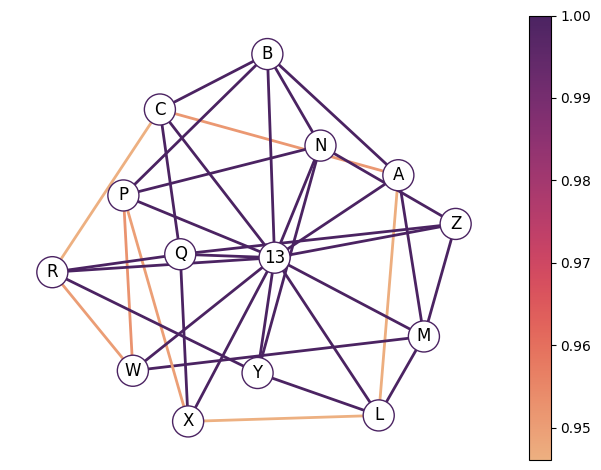

In [41]:
import json
import pandas as pd
import networkx as nx
from nonlocalgames import util
import seaborn as sns

vertices = list(range(14))
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges
shots = 10000

G = nx.Graph()

records = []
for v in vertices:
    counts = nlg.ask((v, v), shots=shots, timeout=0)
    winrate = 0
    for (ca, cb), n in counts.items():
        if ca == cb:
            winrate += n

        records.append({
            'va': v,
            'vb': v,
            'ca': ca,
            'cb': cb,
            'n': n
        })
    
    winrate /= shots
    G.add_node(v, weight=winrate)

for va, vb in edges:
    counts = nlg.ask((va, vb), shots=shots, timeout=0)
    winrate = 0
    for (ca, cb), n in counts.items():
        if ca != cb:
            winrate += n

        records.append({
            'va': va,
            'vb': vb,
            'ca': ca,
            'cb': cb,
            'n': n
        })
    
    winrate /= shots
    if G.has_edge(vb, va):
        w = G.edges[vb, va]['weight']
        G.edges[vb, va]['weight'] = min(winrate, w)
    else:
        G.add_edge(va, vb, weight=winrate)

# Relabel the graph nodes
with open('src/nonlocalgames/data/g13.json', 'r', encoding='utf-8') as f:
    g14_labels = json.load(f)

for n, label in enumerate(g14_labels['vertices']):
    G.nodes[n]['label'] = label.upper()

df = pd.DataFrame.from_records(records)

def winrate(gdf: pd.DataFrame):
    if np.all(gdf.va == gdf.vb):
        return gdf.loc[gdf.ca == gdf.cb].n.sum() / shots
    else:
        return gdf.loc[gdf.ca != gdf.cb].n.sum() / shots

wr = df.groupby(['va', 'vb']).apply(winrate).reset_index(name='win_rate')
df.to_csv('data/g14_constrained/g14_responses.csv', index=False)
wr.to_csv('data/g14_constrained/g14_winrate.csv', index=False)

initial_pos = {
    0: [0, 1],
    1: [np.cos(-np.pi/6), np.sin(-np.pi/6)],
    2: [np.cos(-4*np.pi/6), np.sin(-4*np.pi/6)]
}

# G.remove_node(13)
util.draw_graph(G,
                sns.color_palette('flare', as_cmap=True),
                initial_pos=None)
plt.tight_layout()
plt.savefig('plots/g14_constrained/graph.png', dpi=300)
plt.savefig('plots/g14_constrained/graph.pdf')
plt.show()

## Run Strategy on IBMQ

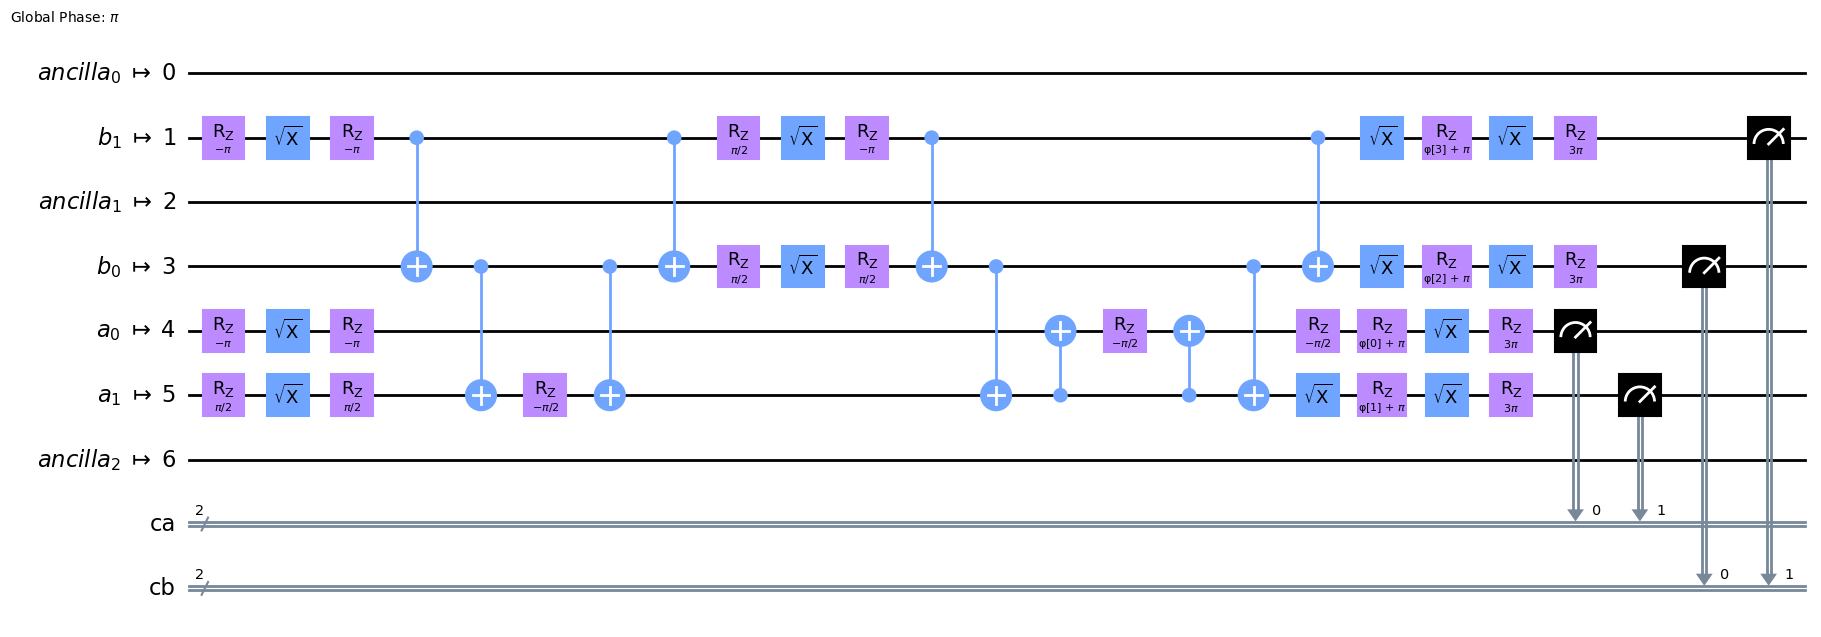

In [22]:
from qiskit_ibm_provider import IBMProvider as IBMQ

dev = 'ibmq_jakarta'
ibmq = IBMQ(name='vt')
backend = ibmq.get_backend(dev)

nlg = NLGCircuit(shared_state, phi, sim=backend)
nlg.transpiled.draw('mpl')

In [24]:
import json
import pandas as pd
import networkx as nx
from nonlocalgames import util
import seaborn as sns
from qiskit.providers import JobV1 as Job

vertices = [(v, v) for v in range(14)]
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges
shots = 1024

job: Job = nlg.ask(questions, timeout=1, shots=shots)
job

<IBMCircuitJob('cjjq5in6hmsgmh16dr4g')>

In [25]:
job.wait_for_final_state()

In [26]:
count_results = nlg._transform_results(job.result())

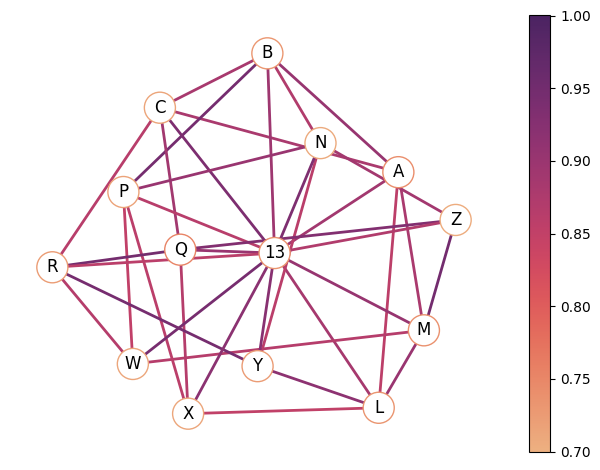

In [33]:
G = nx.Graph()

records = []
for (va, vb), counts in zip(questions, count_results):
    winrate = 0
    for (ca, cb), n in counts.items():
        if ca == cb and va == vb:
            winrate += n
        elif ca != cb and va != vb:
            winrate += n

        records.append({
            'va': va,
            'vb': vb,
            'ca': ca,
            'cb': cb,
            'n': n
        })
    
    winrate /= shots
    if va == vb:
        G.add_node(va, weight=winrate)
    else:
        if G.has_edge(vb, va):
            w = G.edges[vb, va]['weight']
            G.edges[vb, va]['weight'] = min(winrate, w)
        else:
            G.add_edge(va, vb, weight=winrate)

# Relabel the graph nodes
with open('src/nonlocalgames/data/g13.json', 'r', encoding='utf-8') as f:
    g14_labels = json.load(f)

for n, label in enumerate(g14_labels['vertices']):
    G.nodes[n]['label'] = label.upper()

df = pd.DataFrame.from_records(records)

def winrate(gdf: pd.DataFrame):
    if np.all(gdf.va == gdf.vb):
        return gdf.loc[gdf.ca == gdf.cb].n.sum() / shots
    else:
        return gdf.loc[gdf.ca != gdf.cb].n.sum() / shots

wr = df.groupby(['va', 'vb']).apply(winrate).reset_index(name='win_rate')
df.to_csv(f'data/g14_constrained/g14_responses_{dev}.csv', index=False)
wr.to_csv(f'data/g14_constrained/g14_winrate_{dev}.csv', index=False)

util.draw_graph(G,
                sns.color_palette('flare', as_cmap=True),
                initial_pos=None,
                vmin=0.7, vmax=1.0)
plt.tight_layout()
plt.savefig(f'plots/g14_constrained/graph_{dev}.png', dpi=300)
plt.savefig(f'plots/g14_constrained/graph_{dev}.pdf')
plt.show()

## Compare the questions by device

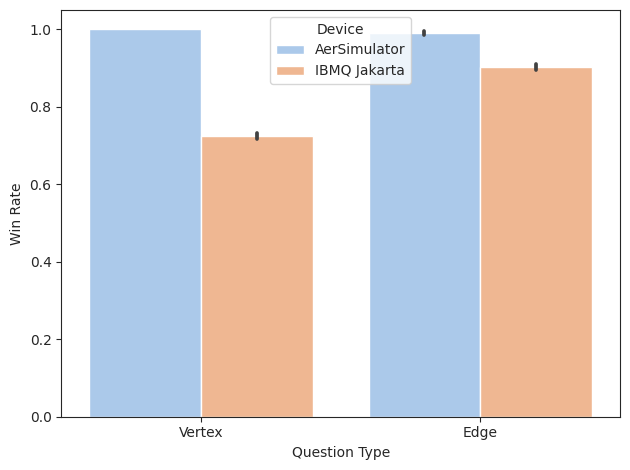

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('pastel')
sns.set_style('ticks')

aerdf = pd.read_csv('data/g14_constrained/g14_winrate.csv')
aerdf['Device'] = 'AerSimulator'
ibmqdf = pd.read_csv('data/g14_constrained/g14_winrate_ibmq_jakarta.csv')
ibmqdf['Device'] = 'IBMQ Jakarta'

df = pd.concat((aerdf, ibmqdf), ignore_index=True)

df['qtype'] = np.where(df.va == df.vb, 'Vertex', 'Edge')

sns.barplot(data=df, x='qtype', y='win_rate', hue='Device')
plt.xlabel('Question Type')
plt.ylabel('Win Rate')
plt.tight_layout()
plt.savefig('plots/g14_constrained/byquestion.png', dpi=300)
plt.savefig('plots/g14_constrained/byquestion.pdf')
plt.show()